**Summary**

Sample Data:
Counter movement jump recorded with Force plate and IMU
FP data collected @ 500 Hz
IMU data collected @ 208 Hz

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import signal

**Select Data Source and Jump Type**

Load the sample file provided in your exam into the sample_data_FP and sample_data_IMU variales for the cmj. These have been indicated by surrounding them in ###

In [2]:
jump = "cmj"           #choose your jump type, it can be cmj or squat
data_type = "csv"        #enter your data type, you must use either csv or xlsx
data_source = "sample"   #Choose your data source - Enter either sample or experimental

#Select correct file to load if data_source is experimental. This will also prompt with a warning if your jump type is not set.
if jump == "cmj":

################################################################################################################################

    sample_data_FP = 
     
    sample_data_IMU = 

###############################################################################################################################

else :
    print("Select either cmj or squat jump") 
    
experimental_data_FP = "Enter file Path here"    #Select your force plate data from your computer or online resource
experimental_data_IMU = "Enter file Path here"   #Select your IMU data from your computer or online resource

sample_rate_FP = 500     #Enter your FP sample rate here, default is 500
sample_rate_IMU = 208    #Enter your IMU sammple rate here, defauly is 208

**Load Data**
Loads data from the selected source

In [3]:
if data_source == "sample":
    if jump== "cmj":
        sample_rate_FP = 500     #Enter your FP sample rate here, default is 500
        sample_rate_IMU = 208    #Enter your IMU sammple rate here, defauly is 208
    elif jump== "squat": 
        #Sample squat jump data are collected at 1000Hz FP and 120Hz IMU
        sample_rate_FP = 1000     #Enter your FP sample rate here, default is 500
        sample_rate_IMU = 120     #Enter your IMU sammple rate here, defauly is 208
        
    raw_FP_data = pd.read_csv(sample_data_FP, header= 0)
    raw_IMU_data = pd.read_csv(sample_data_IMU, header= 0)


elif data_source == "experimental":
   
    if data_type == "xlsx":
        raw_FP_data = pd.read_excel(experimental_data_FP)
        raw_IMU_data = pd.read_excel(experimental_data_IMU)
    elif data_type == "csv":
        raw_FP_data = pd.read_csv(experimental_data_FP)
        raw_IMU_data = pd.read_csv(experimental_data_IMU)
    else:
        print("Error: You must select your data_type")

print(raw_FP_data.head())
print(raw_IMU_data.head())

   Time (s) Auto      FN
0          0.000  865.37
1          0.002  865.77
2          0.004  866.11
3          0.006  865.89
4          0.008  866.05
   timestamp         x         y         z
0    72805.6  0.208183  9.641027  1.371136
1    72810.5  0.260827  9.664956  1.340029
2    72815.4  0.232112  9.684099  1.368743
3    72820.2  0.234505  9.612311  1.265848
4    72825.1  0.251255  9.638634  1.320885


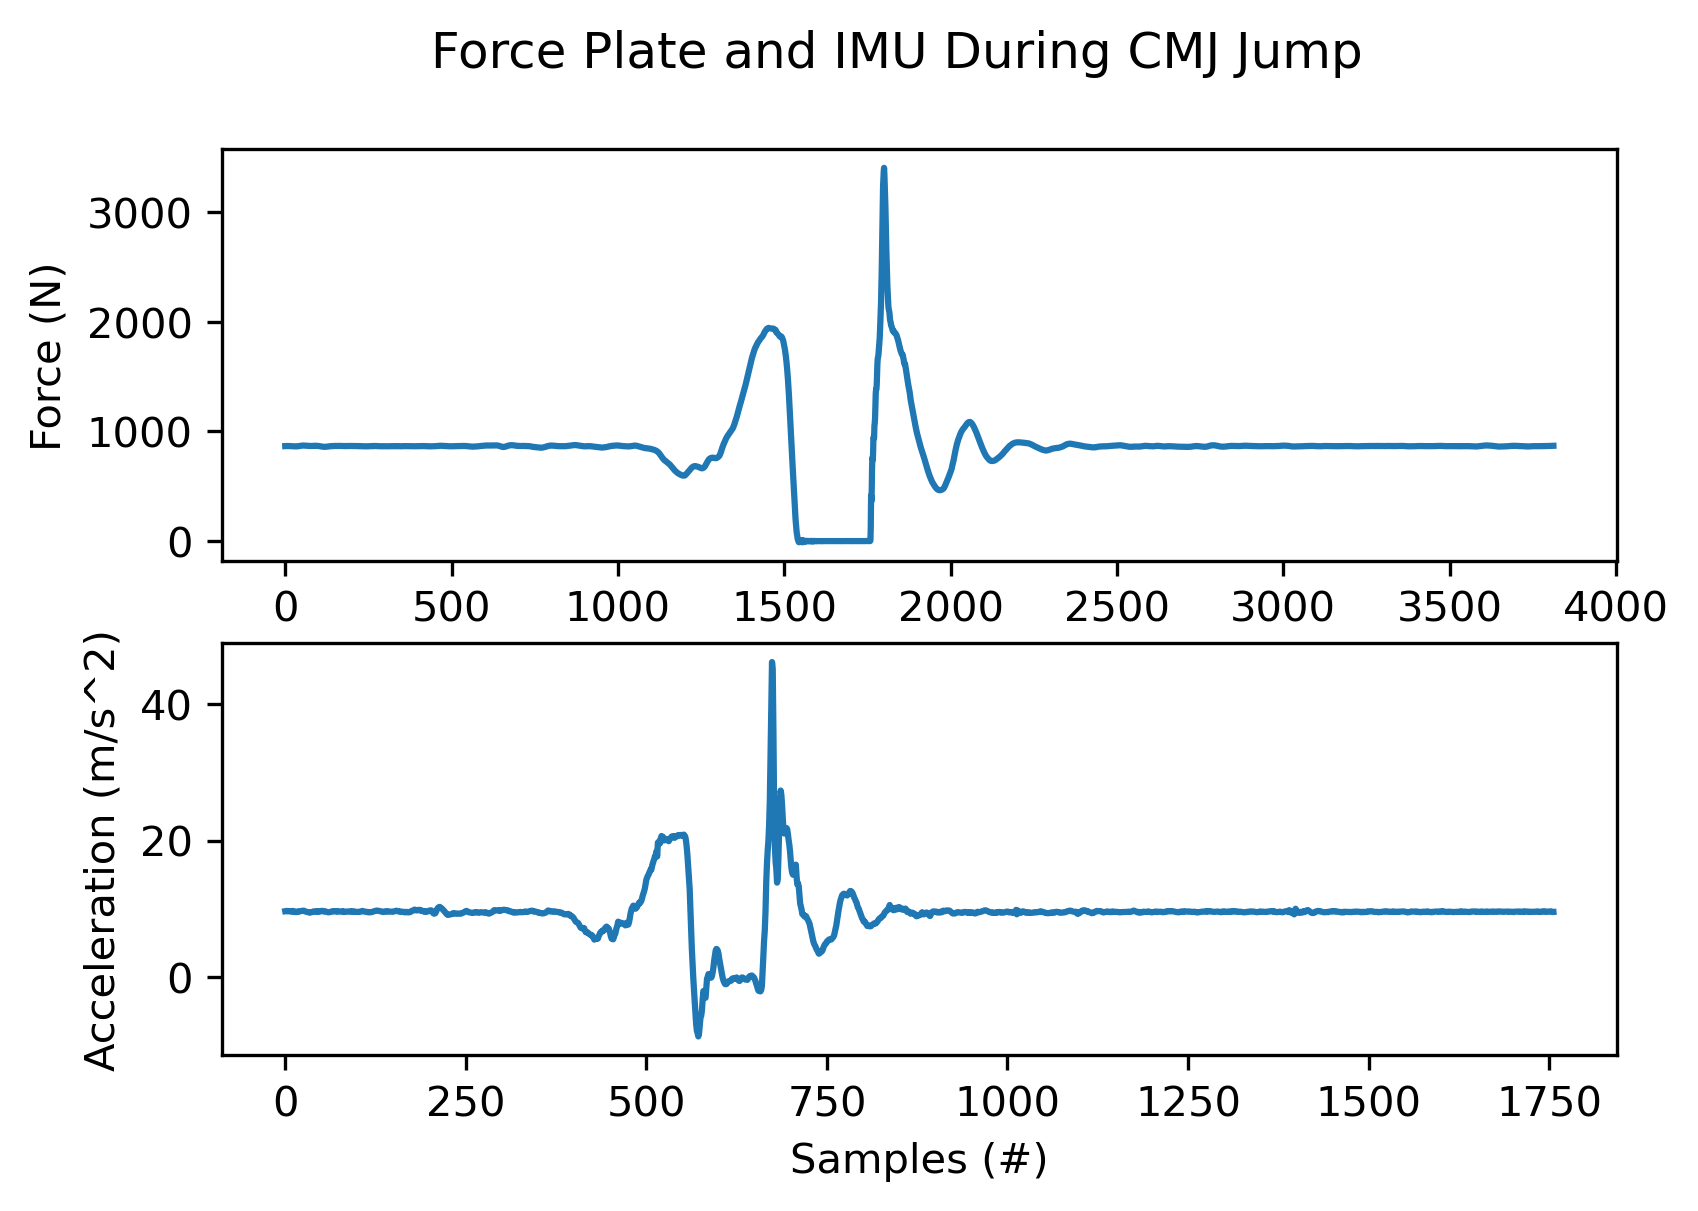

In [4]:
axis_FP= raw_FP_data['FN']
axis_IMU = raw_IMU_data['y']

fig, (ax1, ax2) = plt.subplots(2, dpi=300)
fig.suptitle("Force Plate and IMU During " + jump.upper() + " Jump")
ax1.plot(axis_FP.index, axis_FP)
ax1.set_xlabel("Sample (#)")
ax1.set_ylabel("Force (N)")
ax2.plot(axis_IMU.index, axis_IMU)
ax2.set_xlabel("Samples (#)")
ax2.set_ylabel("Acceleration (m/s^2)")

fig.set_size_inches(6, 4, forward=True)


In [5]:
if data_source != "sample":

    crop_fp_start = 0                    # Enter the approximate start index for your force data
    crop_fp_end = len(raw_FP_data-1)     # Enter the approximate end index for your force data (default is last index) 
    
    raw_FP_data = raw_FP_data.iloc[crop_fp_start:crop_fp_end]
    
    crop_imu_start = 0                  # Enter the approximate start index for your IMU data
    crop_imu_end = len(raw_IMU_data-1)  # Enter the approximate end index for your IMU data
    
    raw_IMU_data = raw_IMU_data.iloc[crop_imu_start:crop_imu_end]
    
    axis_FP= raw_FP_data['FN']
    axis_IMU = raw_IMU_data['y']
    
    fig, (ax1, ax2) = plt.subplots(2, dpi=300)
    fig.suptitle("Raw Force plate and IMU Data")
    ax1.plot(axis_FP.index, axis_FP)
    ax1.set_xlabel("Samples (#)")
    ax1.set_ylabel("Force (N)")
    ax2.plot(axis_IMU.index, axis_IMU)
    ax2.set_xlabel("Samples (#)")
    ax2.set_ylabel("Acceleration (m/s^2)")
    
    fig.set_size_inches(6, 4, forward=True)

else: 
    pass


In [6]:
rolling_std = raw_FP_data["FN"].rolling(50).std()
rolling_std_array = rolling_std.to_numpy()

start_jump = rolling_std.where(rolling_std >10).first_valid_index() #using Pandas method of .where

quiet_stance_thresh = np.where(np.logical_and(rolling_std_array >-2, rolling_std_array <2))[0] #using numpy method of .where which returns a tuple with an empty second member so we use [0]
quiet_stance = np.where(quiet_stance_thresh < start_jump)[0]

quiet_start = quiet_stance_thresh[quiet_stance[0]]
quiet_end = quiet_stance_thresh[quiet_stance[-1]]

In [7]:
bw = raw_FP_data['FN'].iloc[quiet_start:quiet_end].mean() 

g = 9.81
m = round(bw/g, 3)

proc_data = pd.DataFrame()
proc_data_IMU= pd.DataFrame()

proc_data["Net Force"] = raw_FP_data["FN"]-bw

In [8]:
offset_method_IMU = "standard" #Choose to calculate offset as standard( -9.81) OR calculated (determine avg during quiet stance) 

rolling_std_IMU = raw_IMU_data["y"].rolling(50).std()
rolling_std_array_IMU = rolling_std_IMU.to_numpy()    #numpy array created from rolling SD so that np.logical_and can be used

start_jump_IMU = rolling_std_IMU.where(rolling_std_IMU >.5).first_valid_index() #using Pandas method of .where

quiet_thresh_IMU = np.where(np.logical_and(rolling_std_array_IMU >-0.25, rolling_std_array_IMU <0.25))[0] #using numpy method of .where which returns a tuple with an empty second member so we use [0]
quiet_stance_IMU = np.where(quiet_thresh_IMU < start_jump_IMU)[0]
     
quiet_start_IMU = quiet_thresh_IMU[quiet_stance_IMU[0]]
quiet_end_IMU = quiet_thresh_IMU[quiet_stance_IMU[-1]]


if offset_method_IMU == "standard":
    proc_data_IMU["Acc Offset"] = raw_IMU_data['y'] - g
    
else:
    offset_IMU = raw_IMU_data['y'][quiet_start_IMU : quiet_end_IMU].mean() 
    proc_data_IMU["Acc Offset"] = raw_IMU_data['y'] - offset_IMU
    
acc_data = proc_data_IMU["Acc Offset"].dropna().to_numpy()

real_t=np.arange(len(acc_data))*(1/sample_rate_IMU) #create real time column using sample rate

In [9]:
#Function to integrate and detrend data:
def int_detrd(data, sample_freq, detrnd_setting):
    integ=integrate.cumulative_trapezoid(data, x=None, dx=1/sample_freq, initial=0) #Trapezoidal sum
    if detrnd_setting == "yes":
        detrnd=signal.detrend(integ, type="linear") #detrend the data
        ser= pd.Series(detrnd)
    else:
        ser= pd.Series(integ)
    return ser


proc_data["Acceleration FP"] = proc_data["Net Force"]/m

proc_data["Velocity FP"] = int_detrd(proc_data["Acceleration FP"], sample_rate_FP, "yes")

proc_data["Displacement FP"] = int_detrd(proc_data["Velocity FP"], sample_rate_FP, "yes")

In [10]:

#Filter IMU data:
fc = 5  # Cut-off frequency of the filter
w = fc / (sample_rate_IMU / 2) # Normalize the frequency
b, a = signal.butter(2, w, btype= 'lowpass', analog=False) #double butterworth 
filtered_x = signal.filtfilt(b, a, acc_data, padlen = 20)
filt_acc = pd.Series(filtered_x)
proc_data_IMU["Filtered IMU"] = filt_acc


#Calculate velocity from filtered IMU acceleration + detrend data:
v_IMU= int_detrd(filt_acc, sample_rate_IMU, "yes")

#Calculate displacement from v_IMU + detrend data:
d_IMU= int_detrd(v_IMU, sample_rate_IMU, "no")

In [11]:
if jump != "squat":
    #Find end of Unweighting using first rising zero crossing
    #need to convert Acc to numpy array
    
    acc_array = proc_data["Acceleration FP"].to_numpy()
    
    
    a_diff = np.diff(np.sign(acc_array)) #Calculate array differences and find sign change
    
    # Rising zero crossings, outputs are boolean arrays
    rising1 = (a_diff == 2) #Find rising 0 crossing in signal without zero
    rising2 = (a_diff[:-1] == 1) & (a_diff[1:] == 1) #Find rising 0 crossing in signal with zero
    rising_all = rising1
    rising_all[1:] = rising_all[1:] | rising2 # combines rising1 and rising2, output is boolean array
    
    # Zero crossing indices
    rising_zero_loc = np.where(rising_all)[0]  #Find location of True from risingAll and convert from tuple to array of int64
    
    end_unweighting_zero = np.where(rising_zero_loc >start_jump)[0][0] #take the first index of rising_zero_loc after start of unweighting
    end_unweighting = rising_zero_loc[end_unweighting_zero]
    
    # Find end of Braking Phase
    brake_end = proc_data["Displacement FP"].idxmin()

else:
    squat_propulsion = start_jump

#Find peak Velocity
peak_velocity = proc_data["Velocity FP"].idxmax()

#Find take-off: 
take_off = proc_data["Acceleration FP"].where(proc_data["Acceleration FP"] < -g+.05).dropna().first_valid_index() #Find first index where accel is less than 9.81


#Find Landing
reverse_FP = proc_data["Acceleration FP"].iloc[::-1].reset_index(drop=True)
landing = len(proc_data["Acceleration FP"]) - reverse_FP.where(reverse_FP < -g+.05).dropna().first_valid_index()

#Find peak flight
peak_flight = int(take_off + (landing-take_off)/2)

#Peak Landing Force
landing_fmax = proc_data["Net Force"][landing:].idxmax()

# Recovery and quiet stance
recovery_roll_std = proc_data["Net Force"][landing_fmax:].rolling(50).std()    #Calculate rolling SD after peak landing force
recovery_start = recovery_roll_std.where(recovery_roll_std <5).first_valid_index()
recovery_end = recovery_roll_std.where(recovery_roll_std <2).first_valid_index()

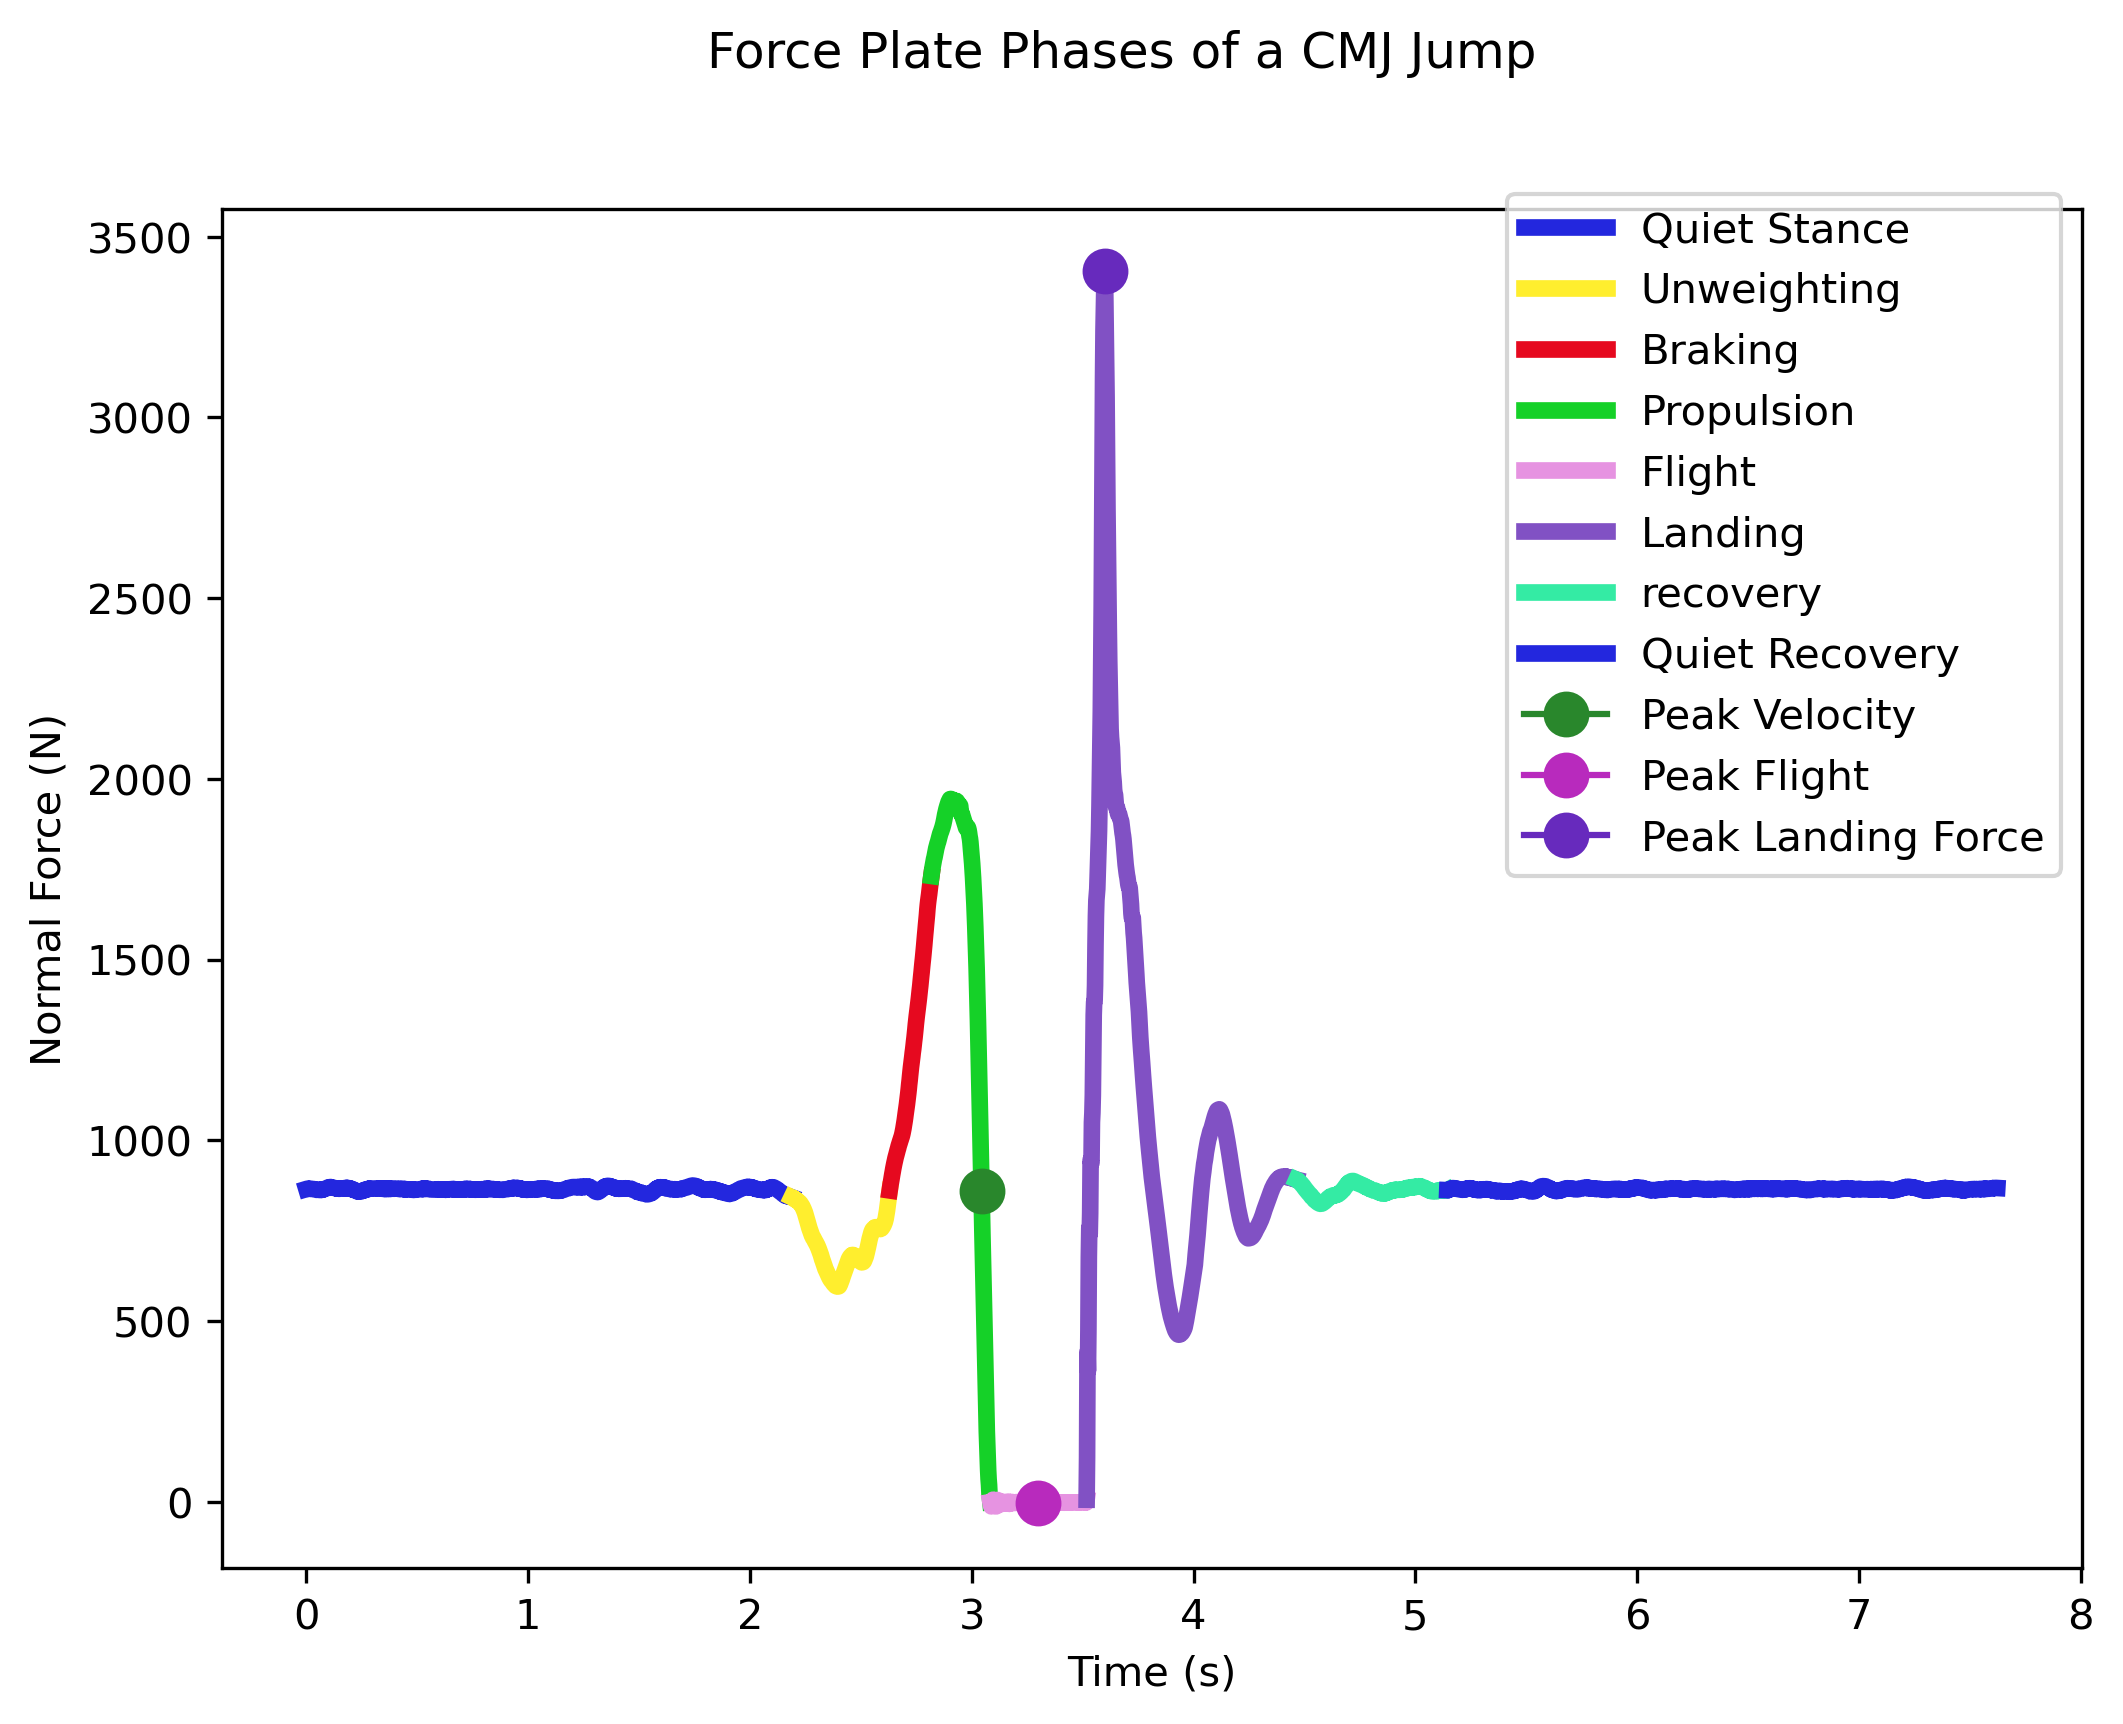

In [12]:
rt_FP= np.arange(0,len(raw_FP_data["FN"]))/sample_rate_FP #create array of Time (s) for FP

fig, ax= plt.subplots(dpi=300)

ax.plot(rt_FP[:start_jump+1],raw_FP_data['FN'].iloc[:start_jump+1], color='#2327de', label= "Quiet Stance", linewidth= 4)

if jump != "squat":
    ax.plot(rt_FP[start_jump:end_unweighting+1], raw_FP_data['FN'].iloc[start_jump:end_unweighting+1], color='#ffee2e', label= "Unweighting", linewidth= 4)
    
    ax.plot(rt_FP[end_unweighting:brake_end+1], raw_FP_data['FN'].iloc[end_unweighting:brake_end+1], color='#e6091f', label= "Braking", linewidth= 4)
    ax.plot(rt_FP[brake_end:take_off+1], raw_FP_data['FN'].iloc[brake_end:take_off+1], color = "#15d128", label= "Propulsion", linewidth= 4)
else:
    ax.plot(rt_FP[start_jump:take_off+1], raw_FP_data['FN'].iloc[start_jump:take_off+1], color = "#15d128", label= "Propulsion", linewidth= 4)

#Create partial plots with color coding for phases    
ax.plot(rt_FP[take_off:landing+1], raw_FP_data['FN'].iloc[take_off:landing+1], color = "#e693e1", label= "Flight", linewidth= 4)
ax.plot(rt_FP[landing:recovery_start+1], raw_FP_data['FN'].iloc[landing:recovery_start+1], color = "#8151c4", label= "Landing", linewidth= 4)
ax.plot(rt_FP[recovery_start:recovery_end+1], raw_FP_data['FN'].iloc[recovery_start:recovery_end+1], color='#34eba4', label= "recovery", linewidth= 4)
ax.plot(rt_FP[recovery_end:], raw_FP_data['FN'].iloc[recovery_end:], color='#2327de', label= "Quiet Recovery", linewidth= 4)

#Plot key points on graph as dots
ax.plot(rt_FP[peak_velocity], raw_FP_data["FN"][peak_velocity], color='#29872c', marker="o", markersize=10, label= "Peak Velocity")
ax.plot(rt_FP[peak_flight], raw_FP_data["FN"][peak_flight], color='#b82abd', marker="o", markersize=10, label= "Peak Flight")
ax.plot(rt_FP[landing_fmax], raw_FP_data["FN"][landing_fmax], color='#672abd', marker="o", markersize=10, label= "Peak Landing Force")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Normal Force (N)")
fig.suptitle("Force Plate Phases of a " + jump.upper() + " Jump")

fig.set_size_inches(8, 6, forward=True)
fig.legend(bbox_to_anchor=(.9,.9))

In [13]:
if jump != "squat":
    # Find end Unweighting
    
    a_diff_IMU = np.diff(np.sign(filt_acc)) #Calculate array differences and find sign change
    
    # Rising zero crossings, outputs are boolean arrays
    rising1_IMU = (a_diff_IMU == 2) #Find rising crossing in signal without zero
    rising2_IMU = (a_diff_IMU[:-1] == 1) & (a_diff_IMU[1:] == 1) #Find rising crossing in signal with zero
    rising_all_IMU = rising1_IMU
    rising_all_IMU[1:] = rising_all_IMU[1:] | rising2_IMU # combines rising1 and rising2, output is boolean array
    
    # Zero crossing indices
    rising_zero_loc_IMU = np.where(rising_all_IMU)[0]  #Find location of True from risingAll and convert from tuple to array of int64
    
    
    #End Unweighting
    end_unweighting_zero_IMU = np.where(rising_zero_loc_IMU >start_jump_IMU)[0][0] #take the first index of rising_zero_loc after start of unweighting
    end_unweighting_IMU = rising_zero_loc_IMU[end_unweighting_zero_IMU]
    
    
    #Find brake_end (lowest CoM)
    v_array = v_IMU.to_numpy()
    v_diff_IMU = np.diff(np.sign(v_array)) #Calculate array differences and find sign change
    
    
    # Rising zero crossings, outputs are boolean arrays
    rising1_vel = (v_diff_IMU == 2) #Find rising crossing in signal without zero
    rising2_vel = (v_diff_IMU[:-1] == 1) & (v_diff_IMU[1:] == 1) #Find rising crossing in signal with zero
    rising_all_vel = rising1_vel
    rising_all_vel[1:] = rising_all_vel[1:] | rising2_vel # combines rising1 and rising2, output is boolean array
    
    
    # Zero crossing indices
    rising_zero_loc_vel = np.where(rising_all_vel)[0]  #Find location of True from risingAll and convert from tuple to array of int64
    
    brake_end_zero_IMU = np.where(rising_zero_loc_vel >start_jump_IMU)[0][0] #take the first index of rising_zero_loc after start of unweighting
    brake_end_IMU = rising_zero_loc_vel[brake_end_zero_IMU]

else:
    squat_propulsion_IMU = start_jump_IMU

#Find take-off
take_off_IMU = proc_data_IMU["Filtered IMU"].where(proc_data_IMU["Filtered IMU"] < -g+.11).dropna().first_valid_index() #Find first index where accel is less than 9.81

#Peak Velocity
peak_vel_IMU = v_IMU.iloc[:take_off_IMU].idxmax()

reverse_IMU = proc_data_IMU["Filtered IMU"].iloc[::-1].reset_index(drop=True)
landing_IMU = len(proc_data_IMU["Filtered IMU"]) - reverse_IMU.where(reverse_IMU < -8).dropna().first_valid_index()

#Find peak flight
peak_flight_IMU = int(take_off_IMU + (landing_IMU - take_off_IMU)/2)


#Peak Landing Acceleration
landing_amax = proc_data_IMU["Filtered IMU"][landing_IMU:].idxmax()

# Recovery and quiet stance
recovery_roll_std_IMU = proc_data_IMU["Filtered IMU"][landing_amax:].rolling(50).std()
recovery_start_IMU = recovery_roll_std_IMU.where(recovery_roll_std_IMU <2).first_valid_index()
recovery_end_IMU = recovery_roll_std_IMU.where(recovery_roll_std_IMU <0.5).first_valid_index()

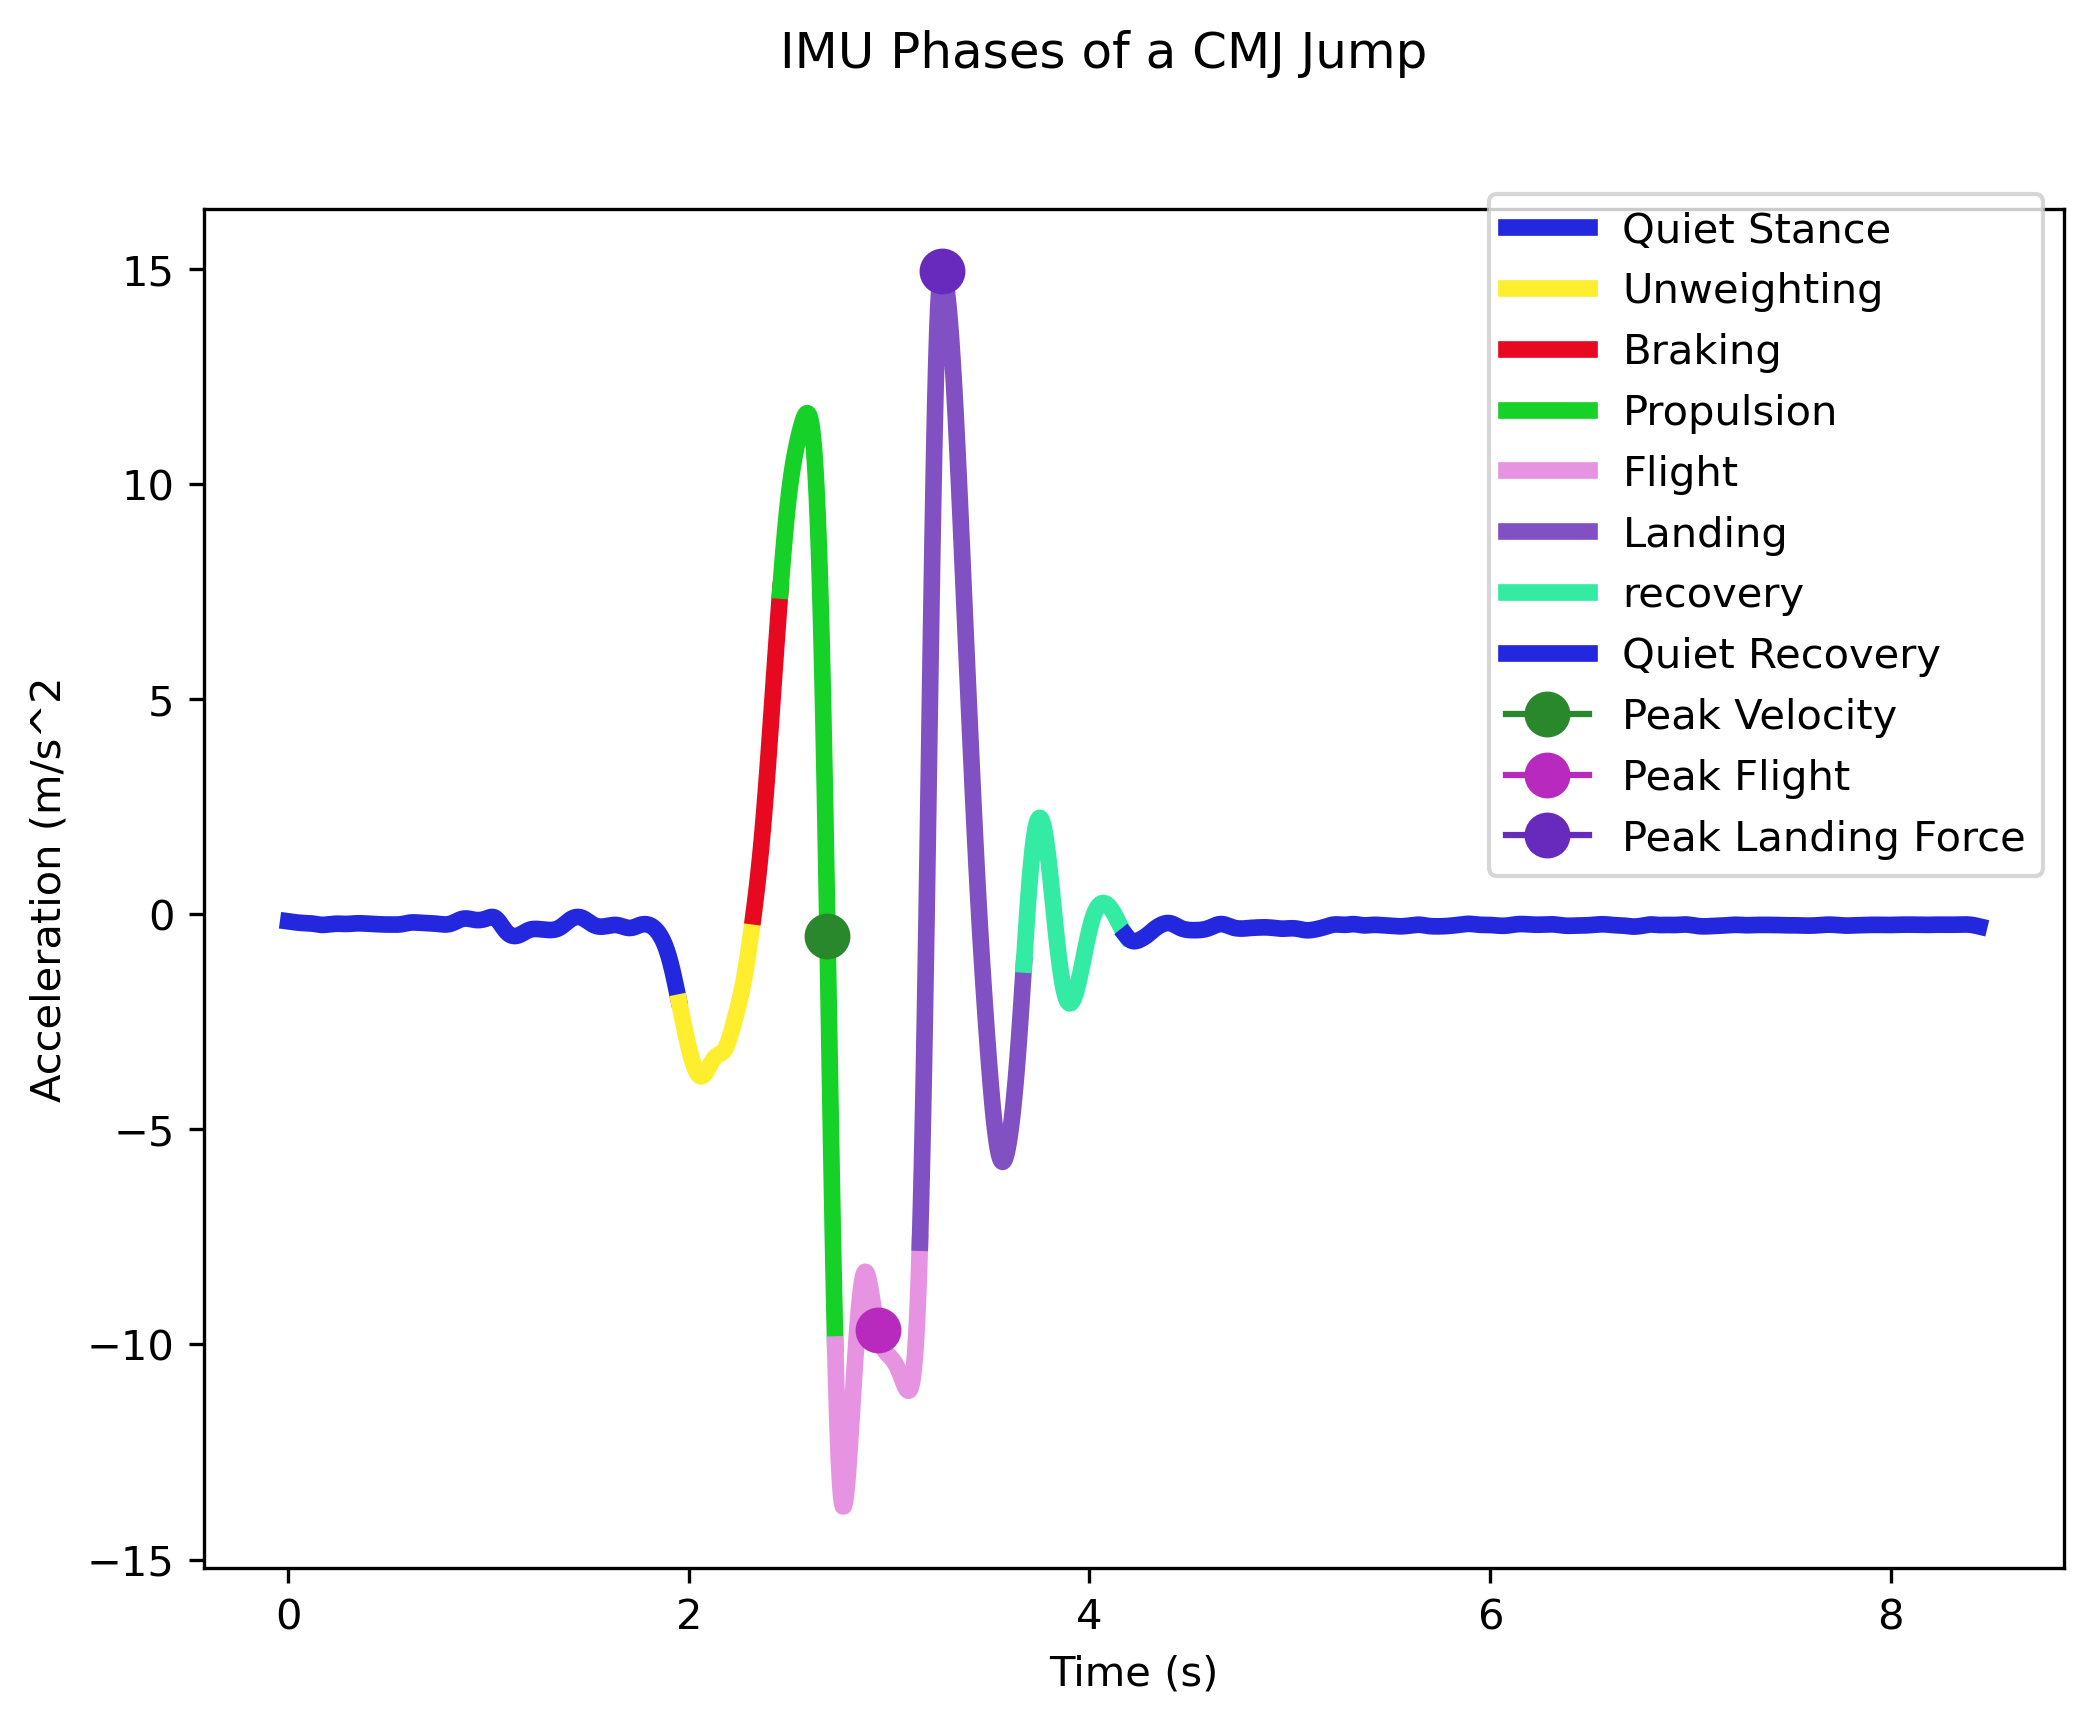

In [14]:
fig, ax= plt.subplots(dpi=300)

ax.plot(real_t[:start_jump_IMU], proc_data_IMU["Filtered IMU"].iloc[:start_jump_IMU], color='#2327de', label= "Quiet Stance", linewidth= 4)

if jump == "cmj":
    ax.plot(real_t[start_jump_IMU : end_unweighting_IMU+1], proc_data_IMU["Filtered IMU"].iloc[start_jump_IMU : end_unweighting_IMU+1], color='#ffee2e', label= "Unweighting", linewidth= 4)
    ax.plot(real_t[end_unweighting_IMU : brake_end_IMU+1], proc_data_IMU["Filtered IMU"].iloc[end_unweighting_IMU : brake_end_IMU+1], color='#e6091f', label= "Braking", linewidth= 4)
    ax.plot(real_t[brake_end_IMU : take_off_IMU+1], proc_data_IMU["Filtered IMU"].iloc[brake_end_IMU : take_off_IMU+1], color = "#15d128", label= "Propulsion", linewidth= 4)
else:
    ax.plot(real_t[start_jump_IMU  : take_off_IMU+1], proc_data_IMU["Filtered IMU"].iloc[start_jump_IMU : take_off_IMU+1], color = "#15d128", label= "Propulsion", linewidth= 4)

#Create partial plots with color coding for phases    
ax.plot(real_t[take_off_IMU : landing_IMU+1], proc_data_IMU["Filtered IMU"].iloc[take_off_IMU : landing_IMU+1], color = "#e693e1", label= "Flight", linewidth= 4)
ax.plot(real_t[landing_IMU : recovery_start_IMU+1], proc_data_IMU["Filtered IMU"].iloc[landing_IMU : recovery_start_IMU+1], color = "#8151c4", label= "Landing", linewidth= 4)
ax.plot(real_t[recovery_start_IMU : recovery_end_IMU+1], proc_data_IMU["Filtered IMU"].iloc[recovery_start_IMU : recovery_end_IMU+1], color='#34eba4', label= "recovery", linewidth= 4)
ax.plot(real_t[recovery_end_IMU:], proc_data_IMU["Filtered IMU"].iloc[recovery_end_IMU:].dropna(), color='#2327de', label= "Quiet Recovery", linewidth= 4)

#Plot key points on graph as dots
ax.plot(real_t[peak_vel_IMU], proc_data_IMU["Filtered IMU"][peak_vel_IMU], color='#29872c', marker="o", markersize=10, label= "Peak Velocity")
ax.plot(real_t[peak_flight_IMU], proc_data_IMU["Filtered IMU"][peak_flight_IMU], color='#b82abd', marker="o", markersize=10, label= "Peak Flight")
ax.plot(real_t[landing_amax], proc_data_IMU["Filtered IMU"][landing_amax], color='#672abd', marker="o", markersize=10, label= "Peak Landing Force")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Acceleration (m/s^2")
fig.suptitle("IMU Phases of a " + jump.upper() + " Jump")

fig.set_size_inches(8, 6, forward=True)
fig.legend(bbox_to_anchor=(.9,.9))

**Force Plate Calculations for Velocity and Jump Height**

List of Forceplate Variables

General variables:
name of dataframe: raw_FP_data
column of dataframe to use: FN
bw   this is the bodyweight in Newtons
g    this is the gravity constant

Phases:
Each phase represents the sample number of where that phase was detected

quiet_start         The beginning of the detected quiet stance
quiet_end           The end of the detected quiet stance
jump_start          The start of unweighting for a countermovement jump
end_unweighting     The end of unweighting for a countermovement jump
brake_end           The end of the braking phase
peak_velocity       The maximum velocity during the jump phase
take_off            The start of the flight phase
landing             The end of the flight phase
peak_flight         The peak of the flight phase
landing_fmax        The maximum landing force
recovery_start      The beginning of the recovery phase
recovery_end        The end of the recovery phase


###############################################################################################################################

In [15]:
#Force Plate Impulse-momentum method
#Enter your data that you want to integrate before the first comma in the integration function. 
#Then, enter the sample duration following dx=

j_GRF= integrate.cumulative_trapezoid(  ,  dx=   , x=None, initial=0) #Trapezoidal Sum of FN vs Time to get J_GRF
j_GRF= j_GRF[-1]                        #Index out (select) the last sample from the J_BW (you don't need to do anything here)

j_BW=                                   #Calculate J_BW OR: bw*((take_off-0)/(1/sample_rate_FP)
                   

j_Res=                                  #Calculate resultant (net) impulse


v_take_off=                             #Calculate take-off velocity using impulse-momentum method


y_height=                               #Calculate flight height


#Force Plate Flight Time method

flight_v_take_off =                    #Calculate take-off velocity using flight time method

flight_y_height =                      #Calculate take-off velocity using flight time method


###############################################################################################################################

In [16]:
print([j_GRF, j_BW, j_Res, v_take_off, y_height, flight_v_take_off, flight_y_height])

[2856.042959999999, 2668.012359358816, 188.031, 2.132, 0.232, 2.129, 0.231]


**IMU Plate Calculations for Velocity and Jump Height**



List of IMU Variables

General variables:
name of dataframe: raw_IMU_data
name of vertical acceleration column in dataframe: y
g    this is the gravity constant

quiet_start_IMU         The beginning of the detected quiet stance
quiet_end_IMU           The end of the detected quiet stance
jump_start_IMU          The start of unweighting for a countermovement jump
end_unweighting_IMU     The end of unweighting for a countermovement jump
brake_end_IMU           The end of the braking phase
peak_velocity_IMU       The maximum velocity during the jump phase
take_off_IMU            The start of the flight phase
landing_IMU             The end of the flight phase
peak_flight_IMU         The peak of the flight phase
landing_fmax_IMU        The maximum landing force
recovery_start_IMU      The beginning of the recovery phase
recovery_end_IMU        The end of the recovery phase


###############################################################################################################################

In [17]:
flight_v_take_off_IMU =                     #Calculate take-off velocity using flight time method

flight_y_height_IMU =                       #Calculate take-off velocity using flight time method


###############################################################################################################################

In [18]:
print([flight_v_take_off_IMU, flight_y_height_IMU])

[2.075, 0.219]
